# Labeling and Visualization of Jazz Music in MIDI

## 0. Setup and Pre-Process

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# read file
df = pd.read_csv('./dataset/Jazz-midi.csv', index_col=0)
unique_notes = df.Unique_notes
file_name = df.midi_filename
len_uni_notes = df.len_Uni_Notes

# drop Notes columns.
df = df.drop(columns=['Notes'])
# drop songs which has less than 32 notes.
df = df.drop(df[df.Len_Sequence <= 32].index)

def get_name(fn):
    words = []
    first = 0 
    for i in range(1, len(fn)-4):     
        if fn[i].isupper() and first<i:
            words.append(fn[first:i])
            first = i  
    words.append(fn[first:len(fn)-4])
    return ' '.join(words)

def filter_numbers(notes):
    ret = []
    notes = notes[1:-1].split(',')
    for note in notes: 
        note = note.strip()
        if not note[1].isdigit():
            ret.append(note[1:-1])
    return ret
    
# insert name column.
name = file_name.apply(get_name)
df.insert(0, 'Song', name)
# update unique_notes column.
unique_notes = unique_notes.apply(filter_numbers)
df.update(unique_notes)
# update len_uni_notes column.
df.update(pd.Series(name='len_Uni_Notes', data=unique_notes.apply(lambda x: len(x))))
# drop songs with invalid notes.
df = df.drop(df[df.len_Uni_Notes <= 1].index)
# rename names.
df = df.rename(columns={'Name':'file_name', 'Song':'Name', 'Len_Sequence':'len_sequence',
                        'Unique_notes':'unique_notes' ,'len_Uni_Notes':'len_uni_notes'})

print('Setup Complete!\n')
# df.to_csv('/Users/todd/Downloads/jazz_notes.csv',)
df.head()

Setup Complete!



Name       midi_filename  len_sequence  \
0       Breeze And I      BreezeAndI.mid           427   
2  Ill Be Seeing You  IllBeSeeingYou.mid           455   
3        Just A Game       JustAGame.mid          1572   
4      Unforgettable   Unforgettable.mid           421   
6   Ghost Ofa Chance  GhostOfaChance.mid           392   

                                        unique_notes  len_uni_notes  
0  [C3, F1, A2, B-0, E-1, E3, B1, G1, D3, G3, E-2...           27.0  
2  [C3, F1, B-0, A2, E-1, D3, B1, G1, G3, E-2, C#...           29.0  
3  [C3, A2, B4, E3, A3, D5, B1, G1, D3, G3, A4, C...           31.0  
4  [A0, C3, F1, A2, E-1, E3, G1, D3, G3, B1, E-2,...           28.0  
6  [A0, B-0, F1, A2, C3, D3, B1, G1, G3, E-2, C#2...           27.0

## 1. Define Features

**Based on the data field after data-washing,  I've made some attmpts to define some features to describe the music.**

$\mathbb{Depth} = \mathcal{Min}(notes)\rightarrow \mathcal{Max}(notes)$

$\mathbb{Length} = \mathcal{Count}(all~notes) $

$\mathbb{Chromaticity} = \mathcal{Count}(unique~notes)$

$\mathbb{Major} = \mathcal{Argmax}(scales~notes) $

In [8]:
# calculate depth
warnings.simplefilter(action='ignore', category=FutureWarning)
level = lambda x: (ord(x[0]) - ord('A')) * int(x[-1]) 
depth = pd.Series(data=[level(max(notes))-level(min(notes)) for notes in df['unique_notes']], dtype=int, name='Depth')
# calculate length
length = pd.Series(data=df['len_sequence'], dtype=int, name='Length')
# calculate chromaticity
chromaticity = pd.Series(data=df['len_uni_notes'], dtype=int, name='Chromaticity').dropna()
# calculate major
major = []
for notes in df['unique_notes']:
    scale = {}
    for note in notes:
        scale[note[-1]] = scale[note[-1]] + 1 if scale.__contains__(note[-1]) else 1
    major.append(max(scale, key=scale.get))
   
major = pd.Series(data=major, dtype=int, name='Major')

# define features
features = pd.concat([depth, length, chromaticity, major], axis=1)
features = features.dropna()
features.index = range(len(features))
depth, length, chromaticity, major = features['Depth'], features['Length'], features['Chromaticity'], features['Major']
print("Completed")

Completed


# 2. Matplotlib Viz
###  Features Distribution Histogram

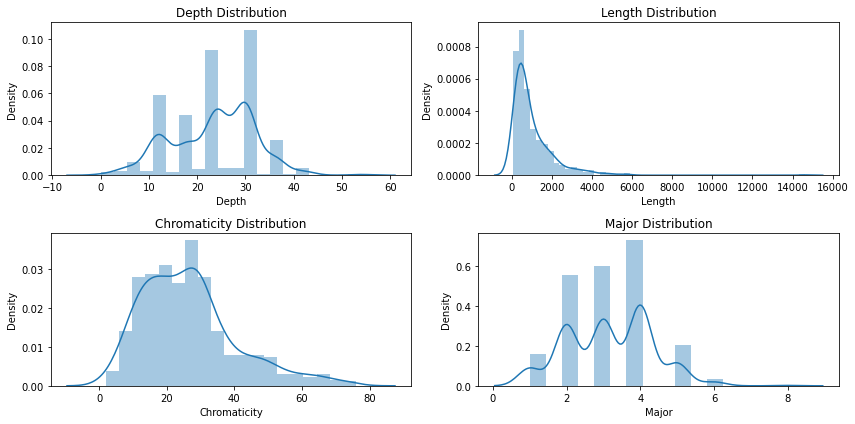

In [9]:
def distplot(idx, data, name):
    plt.subplot(2, 2, idx)
    plt.title(name+' Distribution')
    sns.distplot(data, norm_hist=True)

plt.figure(figsize=(12,6))
distplot(1, depth, 'Depth')   
distplot(2, length, 'Length')  
distplot(3, chromaticity, 'Chromaticity')  
distplot(4, major, 'Major')  
plt.tight_layout()

plt.show()

### Person-Correlation Heatmap

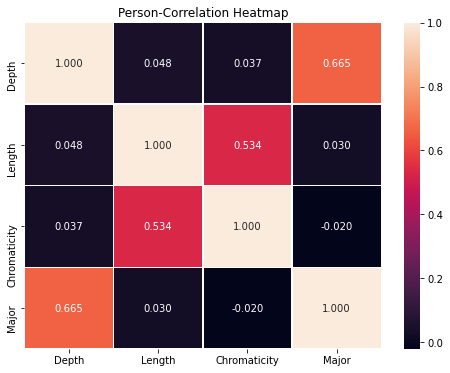

In [10]:
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(features.corr(), annot=True, linewidths=.5, fmt= '.3f', ax=ax)
plt.title("Person-Correlation Heatmap")
plt.show()

Note: we can find out that there are 2 **highly relative pairs** of features, which is: 

* *(depth, major)         
* *(length, chromaticity)*

The results showed that the **depth** is a **key influencing factor** to major, and the **length** is a **key influencing factor** to chromaticity, which is quite intuitive and reasonable.


## 3. Define Music Tags
Based on the features and observations above, I've made some attempts to define some tags. 

In order to **reduce the correlation impacts** of features, we use several combinations with the 2 highly relative pairs excluded to define some interesting tags.

$\mathbb{Classic} = \{\mathcal{Depth}\in [16, 32] \},~~\mathbb{Exotic} = \{\mathcal{Depth}\in (0, 16)\cup (32, \infty]\}$

$\mathbb{Ceased} = \{\mathcal{Length}\in (0, 300)\},~~\mathbb{Epic} = \{\mathcal{Length}\in (3500, \infty]\}$

$\mathbb{Peaceful} = \{\mathcal{Chromaticity}\in (0, 32]\},~~\mathbb{Vivid} = \{\mathcal{Chromaticity}\in (32, \infty)\}$

$\mathbb{Bassy} = \{\mathcal{Major}\in [0, 2]\},~~\mathbb{Harmony} = \{\mathcal{Major}\in [3, 5]\},~~\mathbb{Trebly} = \{\mathcal{Major}\in [6, \infty]\}$

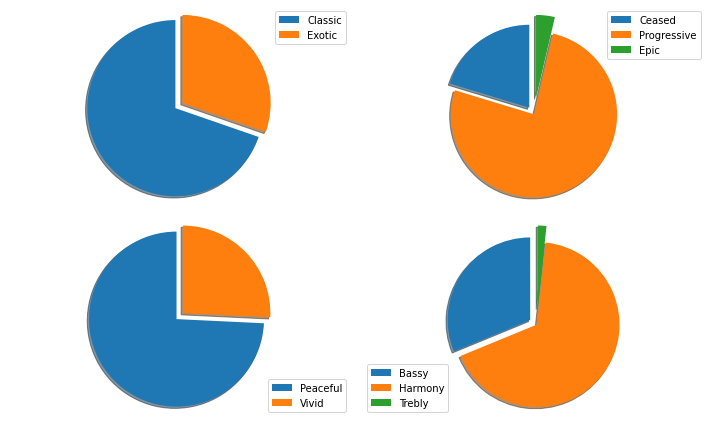

In [11]:
TAGS = [['Classic','Exotic'], ['Ceased', 'Progressive', 'Epic'], ['Peaceful','Vivid'], ['Bassy','Harmony','Trebly']]
    
get_conds = lambda idx: [[depth[idx]>=16 and depth[idx]<=32],\
            [length[idx]<300, length[idx]>3500],\
            [chromaticity[idx]<=32],\
            [major[idx]<=2, major[idx]>=6]]

def get_tags(idx):
    conds = get_conds(idx)
    tags = []
    if conds[0][0]:
        tags.append(TAGS[0][0])
    else:
        tags.append(TAGS[0][1])
        
    if conds[1][0]:
        tags.append(TAGS[1][0])
    elif conds[1][1]:
        tags.append(TAGS[1][2])
    else:
        tags.append(TAGS[1][1])
    
    if conds[2][0]:
        tags.append(TAGS[2][0])
    else:
        tags.append(TAGS[2][1])
    
    if conds[3][0]:
        tags.append(TAGS[3][0])
    elif conds[3][1]:
        tags.append(TAGS[3][2])
    else:
        tags.append(TAGS[3][1])
            
    return tags

tags = pd.Series(data=[' '.join(get_tags(idx)) for idx in features.index], name='Tags')

c_total   = len(tags)
c_classic = sum(tags.str.count('Classic'))
c_ceased  = sum(tags.str.count('Ceased'))
c_epic    = sum(tags.str.count('Epic'))
c_peaceful= sum(tags.str.count('Peaceful'))
c_bassy   = sum(tags.str.count('Bassy'))
c_trebly  = sum(tags.str.count('Trebly'))

data = [[c_classic, c_total-c_classic], 
        [c_ceased, c_total-c_ceased-c_epic, c_epic],
        [c_peaceful, c_total-c_peaceful], 
        [c_bassy, c_total-c_bassy-c_trebly, c_trebly]]

explode = [(0, 0.1), (0.1, 0, 0.2), (0, 0.1), (0.1, 0, 0.2)]
    
def pie(idx):
    plt.subplot(2, 2, idx)
    plt.pie(data[idx-1], shadow=True, startangle=90, explode=explode[idx-1])
    plt.legend(labels=TAGS[idx-1])
    plt.axis('equal')
    

plt.figure(figsize=(10,6))
for i in range(1, 5):
    pie(i)

plt.tight_layout()

In [81]:
print(tags)
print(len(df))

0        Classic Progressive Peaceful Bassy
1      Classic Progressive Peaceful Harmony
2        Classic Progressive Peaceful Bassy
3        Classic Progressive Peaceful Bassy
4        Exotic Progressive Peaceful Trebly
                       ...                 
655    Classic Progressive Peaceful Harmony
656    Classic Progressive Peaceful Harmony
657          Exotic Progressive Vivid Bassy
658       Classic Progressive Vivid Harmony
659               Exotic Epic Vivid Harmony
Name: Tags, Length: 660, dtype: object
794


In [77]:
print(tags[0])
print(len(df))
if "Classic" in tags[0]:
    print("true")

Classic Progressive Peaceful Bassy
794
true


In [79]:
moodnum = []
for x in range(len(tags)):
    if "Exotic" in tags[x]:
        moodnum.append("yes")
    else:
        moodnum.append("no")
print(moodnum)

['no', 'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'yes', 'no', 'yes', 'no', 'yes', 'no', 'no', 'yes', 'no', 'yes', 'no', 'no', 'no', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'yes', 'yes', 'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'yes', 'yes', 'no', 'no', 'yes', 'no', 'no', 'no', 'yes', 'no', 'no', 'yes', 'no', 'yes', 'yes', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'no', 'yes', 'no', 'yes', 'yes', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'yes', 'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'n

## 4. Define How Jazzy a song is
Since it is a jazz music midi dataset, I made a naive definition to described how jazzy a song is.

$\mathbb{S_{Jazzy}} = 5 - \sum_i{\dfrac{\sqrt{(f_i-\overline{f_i})^2}}{\overline{f_i}}}$

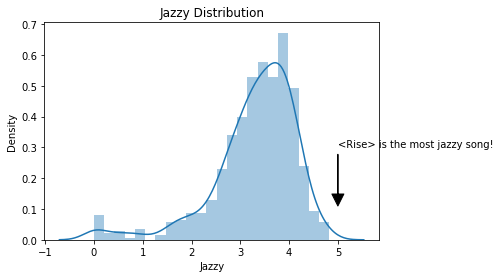

In [13]:
from sklearn.preprocessing import normalize

jazzy = []
for i in features.index:
    jazzy.append(5 - np.sqrt((depth[i] - np.mean(depth))**2)/np.mean(depth) - 
                 np.sqrt((length[i] - np.mean(length))**2)/np.mean(length) -
                 np.sqrt((chromaticity[i] - np.mean(chromaticity))**2)/np.mean(chromaticity) -
                 np.sqrt((major[i] - np.mean(major))**2)/np.mean(major))

filter_zero = lambda x: x if x>0 else 0
filter_five = lambda x: x if x<5 else 5
jazzy = pd.Series(data=jazzy, name='Jazzy').apply(filter_zero).apply(filter_five)

plt.title('Jazzy Distribution')

sns.distplot(jazzy, norm_hist=True)
most_jazzy = np.argmax(jazzy)
plt.annotate('<Rise> is the most jazzy song!', xy=(5, 0.1), xytext=(5,0.3), arrowprops=dict(width=0.2, facecolor='black', shrink=0.05)) 
plt.show()